In [21]:
import os
from matplotlib import pyplot as plt
import numpy as np
import mindspore as ms
import mindspore.context as context
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.nn.metrics import Accuracy
from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import LossMonitor, ModelCheckpoint, CheckpointConfig, TimeMonitor

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")


[WARNING] ME(16160:10204,MainProcess):2026-02-11-18:02:11.875.000 [mindspore\context.py:1334] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.


In [22]:
DATA_DIR_TRAIN="C://Users//user//Huawei Competition//MNIST//train"
DATA_DIR_TEST="C://Users//user//Huawei Competition//MNIST//test"

ds_train = ds.MnistDataset(DATA_DIR_TRAIN)
ds_test = ds.MnistDataset(DATA_DIR_TEST)
print('Data volume of training set: ', ds_train.get_dataset_size())
print('Data volume of test set: ', ds_test.get_dataset_size())
image=ds_train.create_dict_iterator().__next__()
print("Image length/width/channels: ", image['image'].shape)
print("Image label style: ", image['label'])

Data volume of training set:  60000
Data volume of test set:  10000
Image length/width/channels:  (28, 28, 1)
Image label style:  1


In [23]:
def create_dataset(training=True, batch_size=128, resize=(28,28), rescale=1/255, shift=0, buffer_size=64):
    if training:
        data_dir = DATA_DIR_TRAIN
    else:
        data_dir = DATA_DIR_TEST

    # Load the dataset
    dataset = ds.MnistDataset(data_dir)

    # Define the transformations
    resize_op = CV.Resize(size=resize) # Resize the image to the specified size
    rescale_op = CV.Rescale(rescale, shift) # Rescale the image pixel values
    hwc2chw_op = CV.HWC2CHW() # Convert the image from HWC format to CHW format

    # Apply the transformations to the dataset
    dataset = dataset.map(operations=[resize_op, rescale_op, hwc2chw_op], input_columns=["image"])
    dataset = dataset.map(operations=C.TypeCast(ms.int32), input_columns=["label"])

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)

    return dataset

- Clean each image (resize, normalize)

- Arrange them in the right order (channels first)

- Mix them randomly (shuffle)

- Pack them into boxes (batch)

- Send the boxes to the model (return dataset)

[WARNING] ME(16160:10204,MainProcess):2026-02-11-18:02:28.393.000 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(16160:10204,MainProcess):2026-02-11-18:02:28.395.000 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(16160:10204,MainProcess):2026-02-11-18:02:28.397.000 [mindspore\dataset\core\validator_helpers.py:744] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(16160:10204,MainProcess):2026-02-11-18:02:28.397.000 [mindspore\dataset\core\validator_helpers.py:744] 'Typ

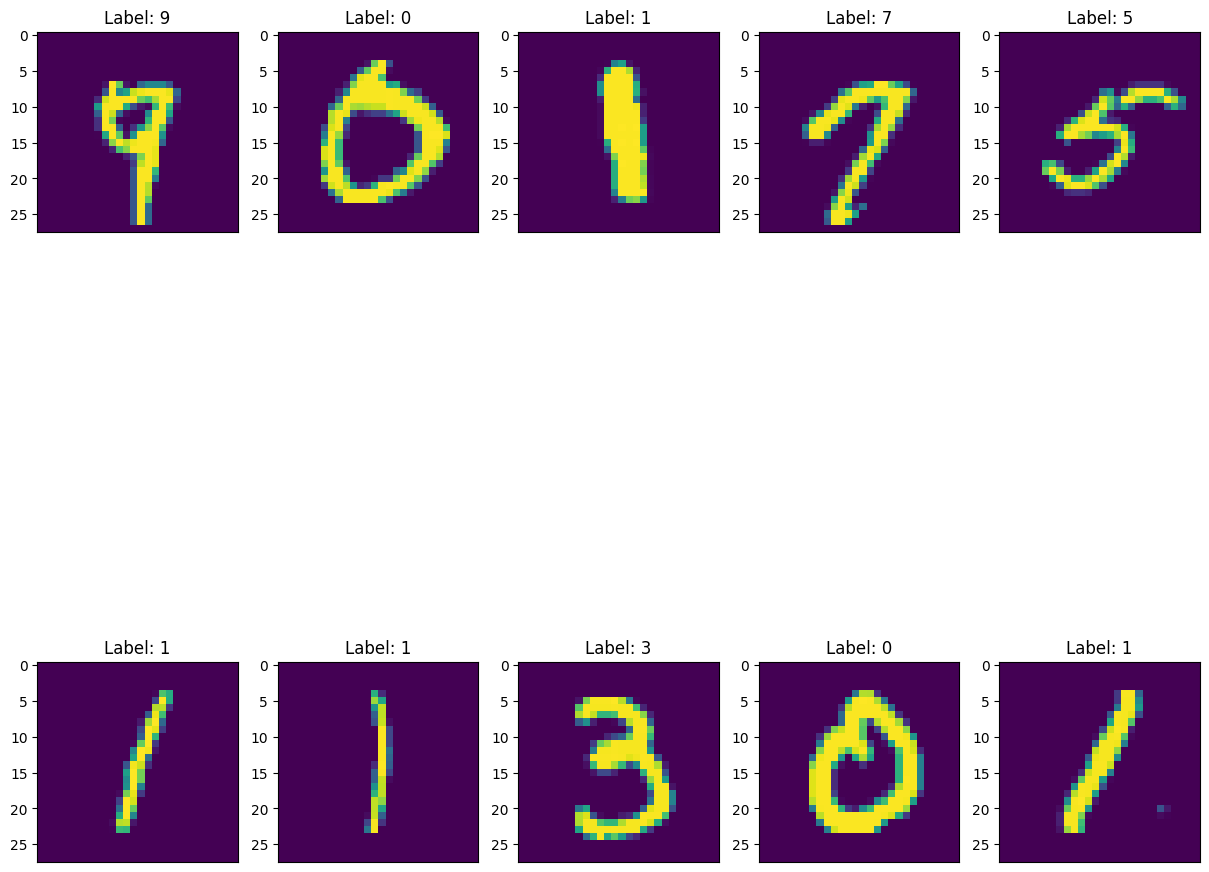

In [24]:
# Display the first 10 images and their labels from the training dataset
ds= create_dataset(training= False)
data= ds.create_dict_iterator().__next__()
images=data['image'].asnumpy()
labels=data['label'].asnumpy()
plt.figure(figsize=(15, 15))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(np.squeeze(images[i]))
    plt.title(f"Label: {labels[i]}")
    plt.xticks([])
plt.show()

In [25]:
# Create a model.The model consists of 3 fully connected layers. The final output layer uses softmax for classification( 10 classes for digits 0-9).
class ForwardNN(nn.Cell):
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(784, 512, activation='relu') # First fully connected layer
        
        self.fc2 = nn.Dense(512, 128, activation='relu') # Second fully connected layer
        
        self.fc3 = nn.Dense(128, 10, activation=None) # Output layer for classification

    def construct(self, input_x):
        output = self.flatten(input_x) # Flatten the input image
        output = self.fc1(output) # Pass through the first fully connected layer
        output = self.fc2(output) # Pass through the second fully connected layer
        output = self.fc3(output) # Pass through the output layer
        return output
       

In [26]:
#Create a network, loss function, validation metric and optimizer and set related hyperparameters.
lr=0.001
num_epochs=10
momentum=0.9

net= ForwardNN()
loss= nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
metric= {'accuracy': Accuracy()}
optimizer= nn.Adam(net.trainable_params(), learning_rate=lr)

In [27]:
model= Model(net, loss_fn=loss, optimizer=optimizer, metrics=metric)
# Configure the checkpoint saving parameters and create a checkpoint callback function.
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_forwardnn", directory="./checkpoint", config=config_ck)
#Generate the dataset for training and validation.
ds_train = create_dataset(training=True, batch_size=32)
ds_val = create_dataset(training=False, batch_size=32)
# Train the model and save the training loss and validation accuracy for each epoch.
loss_cb = LossMonitor(per_print_times=1875)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
model.train(num_epochs, ds_train, callbacks=[loss_cb, time_cb, ckpoint_cb], dataset_sink_mode=False)


AttributeError: 'BatchDataset' object has no attribute 'MnistDataset'

In [ ]:
# Use the test set to evaluate the model's performance and print the test accuracy.
metrics = model.eval(ds_val)
print(f"Test Accuracy: {metrics['accuracy']:.4f}")
print(metrics)
print("Model training and evaluation completed.")

In [ ]:
%pip install opencv-python